Building Classifier
--- You are a data scientist at vacation rental company. So far company was doing good differentiating itself as a company renting single family vacation homes only. Vocation season is about to start, customers renting, and homeowners are listing. Quality control team is overwhelmed. Team is asking is there way to make their life easier. Ypu just accepted the challenge of classifying listing automatically. As a proof of concept you start with 2 big classes residential, industrial. 

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# import os 
# os.chdir('drive/My Drive')

In [0]:
# !unzip staticmap

In [35]:
import torch
import numpy as np

import matplotlib.pyplot as plt

from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5),
                                                           (0.5, 0.5, 0.5))])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5),
                                                          (0.5, 0.5, 0.5))])
# choose the training and test datasets
train_data =  datasets.ImageFolder('staticmap/train', transform=train_transforms)
test_data =  datasets.ImageFolder('staticmap/test', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)


Define Classes

In [0]:
# specify the image classes
classes = ['Industrial', 'Residential']

In [38]:
len(train_idx)

1611

### Visualize a Batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

(20, 3, 120, 120)


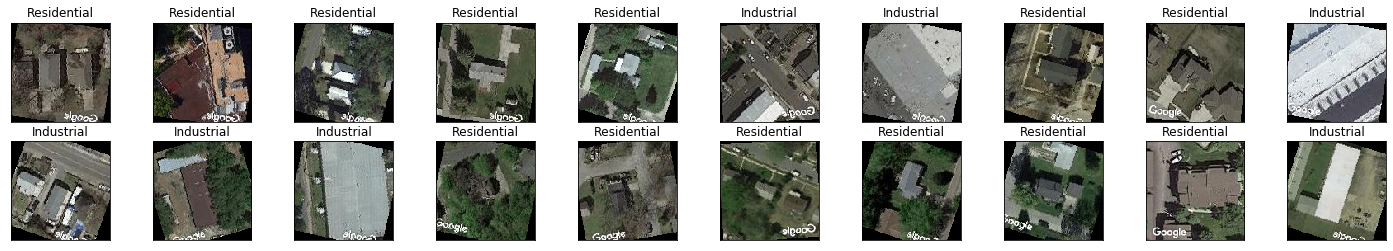

In [40]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [41]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.Features=nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3)
        )
        self.Classifier = nn.Sequential(
            nn.Linear(5*5*128, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 2)   
        )
    def forward(self, x):
        x = self.Features(x)
        x = x.view(-1, 128 * 5 * 5)
        x = self.Classifier(x)
        return x
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (Features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)


In [0]:
 #Use GPU if it's available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Define creterion and optimizer 

In [0]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.Classifier.parameters(), lr=0.001)

model.to(device);

In [44]:
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf

USE_GPU = True # currently GPU not available
use_cuda = USE_GPU and torch.cuda.is_available()

train_loss_coll = []
valid_loss_coll = []
n_epochs = 300

for epoch in range(1, n_epochs+1):
    # initialize variables to monitor training and validation loss
    train_loss = 0.0
    train_correct = 0.
    train_total = 0.
    
    valid_loss = 0.0
    valid_correct = 0.
    valid_total = 0.        
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (train_data, train_target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            train_data, train_target = train_data.cuda(), train_target.cuda()
        # clear the gradients of all optimized variables    
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        train_output = model(train_data)
        # calculate the batch loss
        loss = criterion(train_output, train_target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update total training loss
        train_loss += loss.item()*train_data.size(0)            
        # convert output logits to predicted class
        train_pred = train_output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        train_correct += np.sum(np.squeeze(train_pred.eq(train_target.data.view_as(train_pred))).cpu().numpy())
        train_total += train_data.size(0)
            
        ## find the loss and update the model parameters accordingly
        ## record the average training loss, using something like
        ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for val_batch_idx, (val_data, val_target) in enumerate(valid_loader):
        # move to GPU
        if use_cuda:
            val_data, val_target = val_data.cuda(), val_target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        val_output = model(val_data)
        # calculate the batch loss
        val_loss = criterion(val_output, val_target)
        # update total validation loss 
        valid_loss += val_loss.item()*val_data.size(0)
        # convert output logits to predicted class
        valid_pred = val_output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        valid_correct += np.sum(np.squeeze(valid_pred.eq(val_target.data.view_as(valid_pred))).cpu().numpy())
        valid_total += val_data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    train_acc = 100. * train_correct / train_total
    valid_acc = 100. * valid_correct / valid_total
        
    # print training/validation statistics 
    print('Epoch: {} \tTrain Loss: {:.6f} \tValid Loss: {:.6f} \tTrain Acc: {:.2f} \tValid Acc: {:.2f}'.format(
        epoch, 
        train_loss,
        valid_loss,
        train_acc,
        valid_acc))
    
    train_loss_coll.append(train_loss)
    valid_loss_coll.append(valid_loss)
    
    ## Save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, valid_loss
        ))
        torch.save(model.state_dict(), '/content/drive/My Drive/classifier.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Train Loss: 0.470379 	Valid Loss: 0.103534 	Train Acc: 67.97 	Valid Acc: 74.38
Validation loss decreased (inf --> 0.103534).  Saving model ...
Epoch: 2 	Train Loss: 0.392097 	Valid Loss: 0.095252 	Train Acc: 76.78 	Valid Acc: 79.85
Validation loss decreased (0.103534 --> 0.095252).  Saving model ...
Epoch: 3 	Train Loss: 0.359633 	Valid Loss: 0.092527 	Train Acc: 79.76 	Valid Acc: 79.60
Validation loss decreased (0.095252 --> 0.092527).  Saving model ...
Epoch: 4 	Train Loss: 0.361199 	Valid Loss: 0.097042 	Train Acc: 79.14 	Valid Acc: 79.60
Epoch: 5 	Train Loss: 0.362534 	Valid Loss: 0.092323 	Train Acc: 79.39 	Valid Acc: 80.10
Validation loss decreased (0.092527 --> 0.092323).  Saving model ...
Epoch: 6 	Train Loss: 0.352882 	Valid Loss: 0.091620 	Train Acc: 80.51 	Valid Acc: 80.85
Validation loss decreased (0.092323 --> 0.091620).  Saving model ...
Epoch: 7 	Train Loss: 0.354029 	Valid Loss: 0.090416 	Train Acc: 80.94 	Valid Acc: 80.35
Validation loss decreased (0.091620 -

Visualize Loss History

In [45]:
model.load_state_dict(torch.load('/content/drive/My Drive/classifier.pt'))

<All keys matched successfully>

In [47]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.205140

Test Accuracy of Industrial: 90% (135/150)
Test Accuracy of Residential: 94% (141/150)

Test Accuracy (Overall): 92% (276/300)


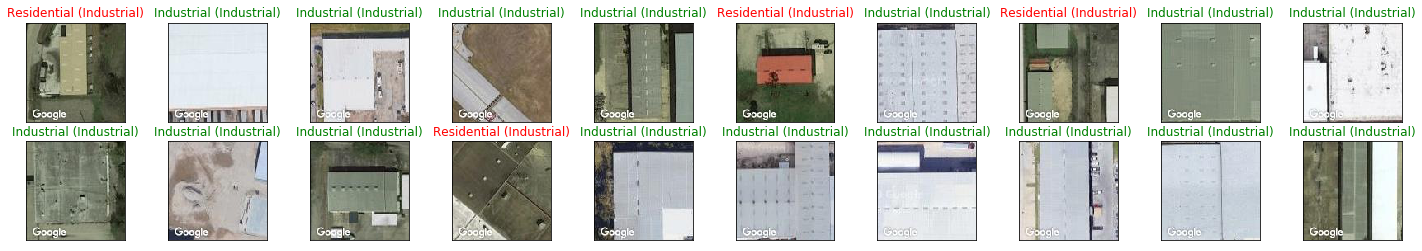

In [46]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))